<a href="https://colab.research.google.com/github/gayathri-bandari/machine-learning-model/blob/main/covid_reinfection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [98]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error, accuracy_score, classification_report
import re
# from textblob import TextBlob # Removed as sentiment analysis is excluded
import plotly.express as px


In [100]:
# --- IMPORTING THE LIBRARIES ---
print("--- Importing Libraries ---")
# Libraries are imported at the beginning of the script.


--- Importing Libraries ---


In [102]:
# --- LOADING THE DATA ---
print("\n--- Loading the Data ---")
file_path = 'covid_related_disease_data (1).csv'
try:
    df = pd.read_csv(file_path)
    print(f"Successfully loaded '{file_path}'. Shape: {df.shape}")
    print("\nFirst 5 rows of the dataset:")
    print(df.head())
    print("\nDataset Info:")
    df.info()
except FileNotFoundError:
    print(f"Error: The file '{file_path}' was not found. Please ensure it's in the correct directory.")
    exit() # Exit if the file cannot be loaded



--- Loading the Data ---
Successfully loaded 'covid_related_disease_data (1).csv'. Shape: (3000, 26)

First 5 rows of the dataset:
   Patient_ID  Age  Gender       Region Preexisting_Condition  \
0           1   69    Male  Hovedstaden               Obesity   
1           2   38    Male     Sjælland                Asthma   
2           3   41  Female   Syddanmark          Hypertension   
3           4   81  Female  Hovedstaden                Asthma   
4           5   50  Female   Syddanmark        Cardiovascular   

  Date_of_Infection COVID_Strain Symptoms  Severity Hospitalized  ...  \
0        2022-06-21        Delta     Mild  Moderate          Yes  ...   
1        2024-02-02      XBB.1.5     Mild  Moderate           No  ...   
2        2023-05-28         Beta     Mild      High          Yes  ...   
3        2023-08-13        Delta   Severe      High           No  ...   
4        2023-03-10        Delta     Mild      High           No  ...   

  Reinfection Date_of_Reinfection Vacc

In [104]:
# --- DATA CLEANING ---
print("\n--- Data Cleaning ---")
print("\nChecking for missing values:")
print(df.isnull().sum())


--- Data Cleaning ---

Checking for missing values:
Patient_ID                    0
Age                           0
Gender                        0
Region                        0
Preexisting_Condition       469
Date_of_Infection             0
COVID_Strain                  0
Symptoms                      0
Severity                      0
Hospitalized                  0
Hospital_Admission_Date    2124
Hospital_Discharge_Date    2124
ICU_Admission                 0
Ventilator_Support            0
Recovered                     0
Date_of_Recovery           1492
Reinfection                   0
Date_of_Reinfection        2715
Vaccination_Status            0
Vaccine_Type               1809
Doses_Received                0
Date_of_Last_Dose          1528
Long_COVID_Symptoms        2780
Occupation                    0
Smoking_Status                0
BMI                           0
dtype: int64


In [106]:
# Example: Filling missing numerical values with median, categorical with mode
for column in df.columns:
    if df[column].dtype == 'object':
        if df[column].isnull().any():
            mode_val = df[column].mode()[0]
            df[column].fillna(mode_val, inplace=True)
            print(f"Filled missing values in '{column}' with mode: {mode_val}")
    elif df[column].dtype in ['int64', 'float64']:
        if df[column].isnull().any():
            median_val = df[column].median()
            df[column].fillna(median_val, inplace=True)
            print(f"Filled missing values in '{column}' with median: {median_val}")

print("\nChecking for duplicates:")
duplicates = df.duplicated().sum()
if duplicates > 0:
    print(f"Found {duplicates} duplicate rows. Removing them.")
    df.drop_duplicates(inplace=True)
    print(f"Dataset shape after removing duplicates: {df.shape}")
else:
    print("No duplicate rows found.")

print("\nBasic data type conversion if necessary (example for a hypothetical 'Date' column):")
# if 'Date' in df.columns:
#     try:
#         df['Date'] = pd.to_datetime(df['Date'])
#         print("Converted 'Date' column to datetime.")
#     except Exception as e:
#         print(f"Could not convert 'Date' column to datetime: {e}")

print("\nData cleaning complete. Updated DataFrame Info:")
df.info()


Checking for duplicates:
No duplicate rows found.

Basic data type conversion if necessary (example for a hypothetical 'Date' column):

Data cleaning complete. Updated DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 26 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Patient_ID               3000 non-null   int64  
 1   Age                      3000 non-null   int64  
 2   Gender                   3000 non-null   object 
 3   Region                   3000 non-null   object 
 4   Preexisting_Condition    3000 non-null   object 
 5   Date_of_Infection        3000 non-null   object 
 6   COVID_Strain             3000 non-null   object 
 7   Symptoms                 3000 non-null   object 
 8   Severity                 3000 non-null   object 
 9   Hospitalized             3000 non-null   object 
 10  Hospital_Admission_Date  3000 non-null   object 
 11  H

In [108]:
# --- EXPLORATORY DATA ANALYSIS (EDA) ---
print("\n--- Exploratory Data Analysis (EDA) ---")
print("\nDescriptive statistics for numerical columns:")
print(df.describe())

print("\nValue counts for top categorical columns (first 5 columns):")
for col in df.select_dtypes(include='object').columns[:5]:
    print(f"\nValue counts for '{col}':")
    print(df[col].value_counts())



--- Exploratory Data Analysis (EDA) ---

Descriptive statistics for numerical columns:
        Patient_ID          Age  Doses_Received          BMI
count  3000.000000  3000.000000     3000.000000  3000.000000
mean   1500.500000    53.944000        0.981667    25.096500
std     866.169729    20.872919        1.154025     4.898435
min       1.000000    18.000000        0.000000    10.200000
25%     750.750000    36.000000        0.000000    21.800000
50%    1500.500000    54.000000        0.000000    25.100000
75%    2250.250000    72.000000        2.000000    28.500000
max    3000.000000    89.000000        3.000000    44.600000

Value counts for top categorical columns (first 5 columns):

Value counts for 'Gender':
Gender
Female    1527
Male      1473
Name: count, dtype: int64

Value counts for 'Region':
Region
Midtjylland    628
Hovedstaden    612
Sjælland       609
Syddanmark     597
Nordjylland    554
Name: count, dtype: int64

Value counts for 'Preexisting_Condition':
Preexisting_

In [110]:
# --- DATA VISUALIZATION ---
print("\n--- Data Visualization ---")



--- Data Visualization ---


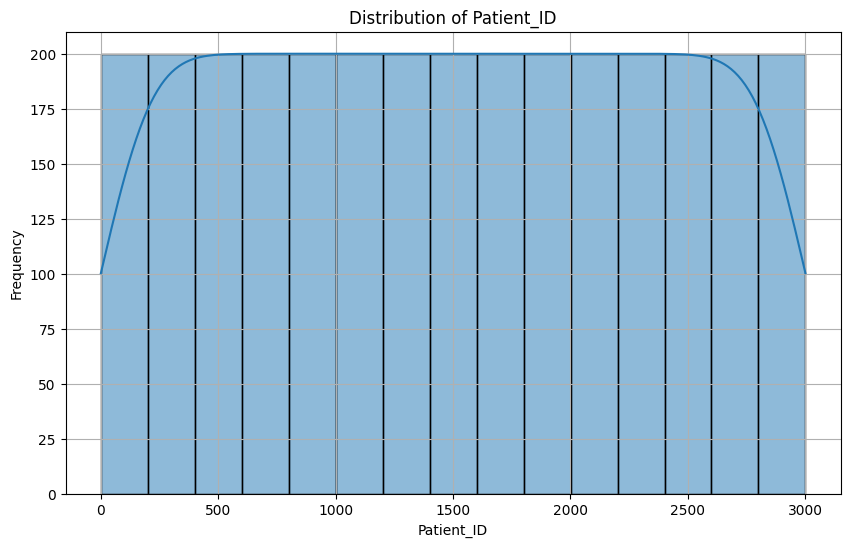

In [112]:
# Example: Distribution of a numerical feature (e.g., first numerical column if exists)
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns
if len(numerical_cols) > 0:
    plt.figure(figsize=(10, 6))
    sns.histplot(df[numerical_cols[0]], kde=True)
    plt.title(f'Distribution of {numerical_cols[0]}')
    plt.xlabel(numerical_cols[0])
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

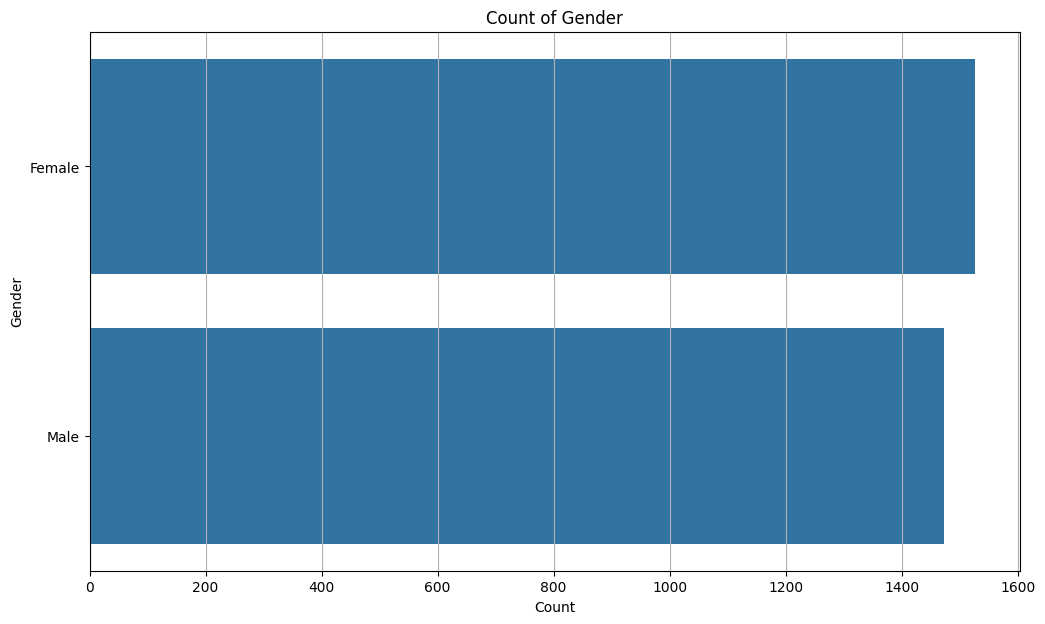

In [114]:
# Example: Bar plot for a categorical feature (e.g., first categorical column if exists)
categorical_cols = df.select_dtypes(include='object').columns
if len(categorical_cols) > 0:
    plt.figure(figsize=(12, 7))
    sns.countplot(y=df[categorical_cols[0]], order=df[categorical_cols[0]].value_counts().index)
    plt.title(f'Count of {categorical_cols[0]}')
    plt.xlabel('Count')
    plt.ylabel(categorical_cols[0])
    plt.grid(axis='x')
    plt.show()


--- Relationship between Two Numerical Features (General Adaptation) ---


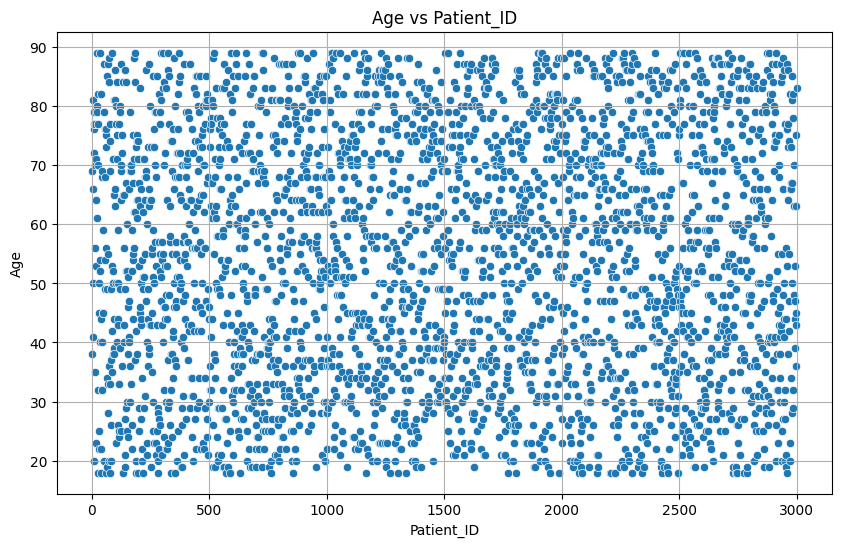

In [116]:
# --- SELLING PRICE VS ORIGINAL PRICE (Adaptation for general data) ---
# This section is highly specific to e-commerce. If the COVID dataset has price-like columns,
# you would rename them. For a generic dataset, we'll demonstrate a scatter plot
# between two arbitrary numerical columns to show relationship.
print("\n--- Relationship between Two Numerical Features (General Adaptation) ---")
if len(numerical_cols) >= 2:
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=df[numerical_cols[0]], y=df[numerical_cols[1]])
    plt.title(f'{numerical_cols[1]} vs {numerical_cols[0]}')
    plt.xlabel(numerical_cols[0])
    plt.ylabel(numerical_cols[1])
    plt.grid(True)
    plt.show()
else:
    print("Not enough numerical columns to show a 'Selling Price vs Original Price' equivalent.")




--- Top Categories Distribution (General Adaptation for 'Brand Distribution') ---


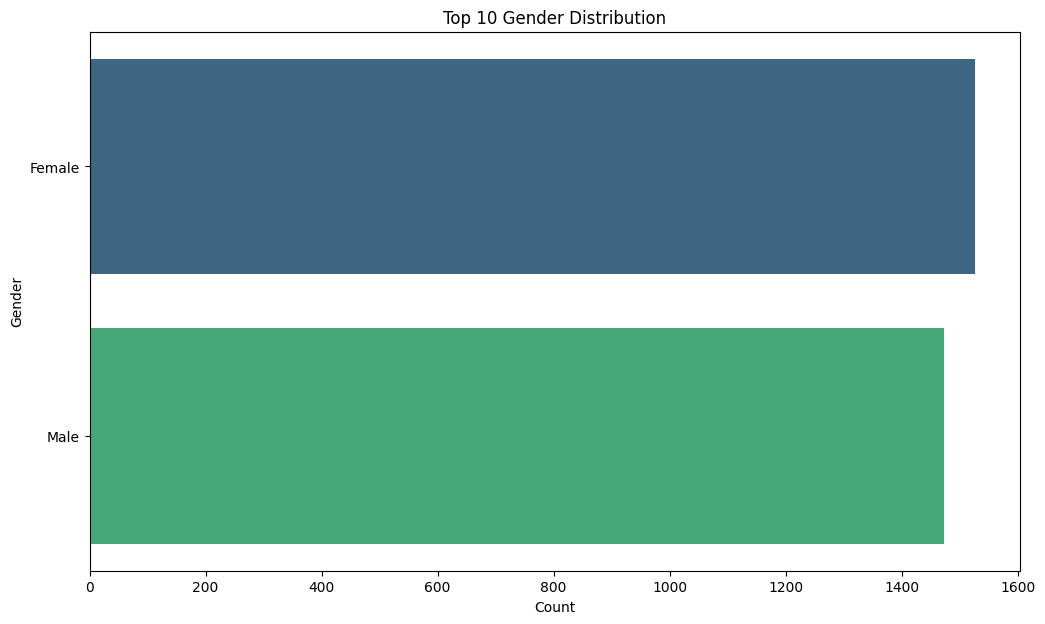

In [118]:
# --- BRAND DISTRIBUTION (Adaptation for general data: Top categories) ---
print("\n--- Top Categories Distribution (General Adaptation for 'Brand Distribution') ---")
if len(categorical_cols) > 0:
    top_categories = df[categorical_cols[0]].value_counts().head(10)
    plt.figure(figsize=(12, 7))
    sns.barplot(x=top_categories.values, y=top_categories.index, palette='viridis')
    plt.title(f'Top 10 {categorical_cols[0]} Distribution')
    plt.xlabel('Count')
    plt.ylabel(categorical_cols[0])
    plt.show()
else:
    print("No categorical columns to show a 'Brand Distribution' equivalent.")



--- Correlation Between Numerical Features ---


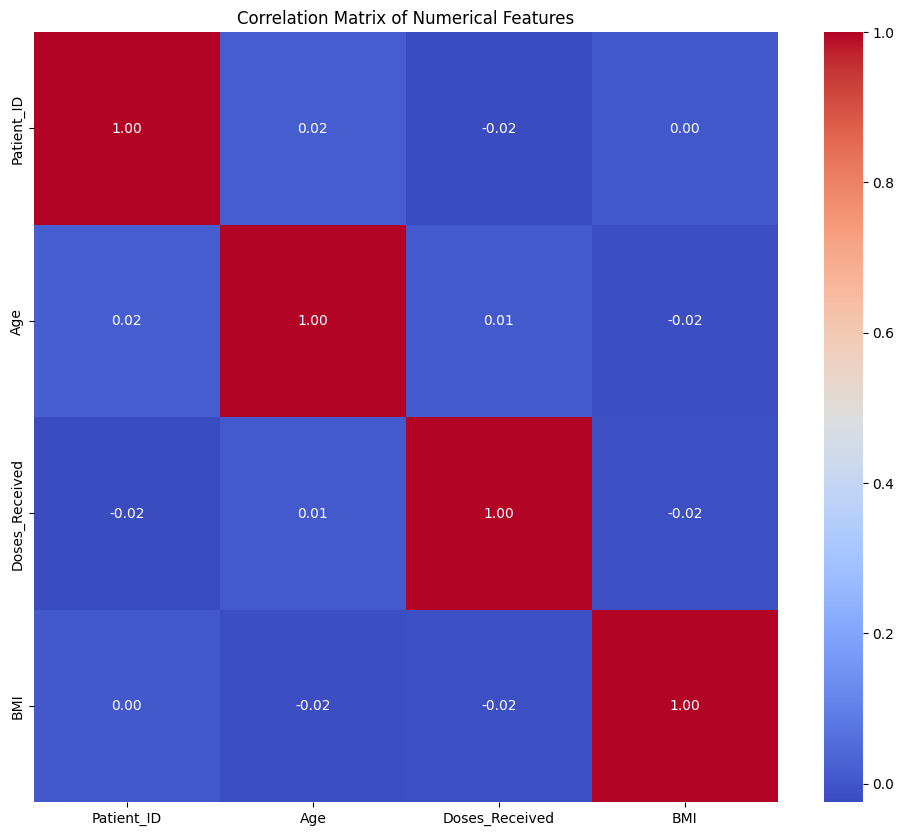


Correlation Matrix:
                Patient_ID       Age  Doses_Received       BMI
Patient_ID        1.000000  0.015757       -0.024647  0.004626
Age               0.015757  1.000000        0.008678 -0.019687
Doses_Received   -0.024647  0.008678        1.000000 -0.015218
BMI               0.004626 -0.019687       -0.015218  1.000000


In [120]:
# --- CORRELATION BETWEEN FEATURES ---
print("\n--- Correlation Between Numerical Features ---")
if len(numerical_cols) > 1:
    correlation_matrix = df[numerical_cols].corr()
    plt.figure(figsize=(12, 10))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title('Correlation Matrix of Numerical Features')
    plt.show()
    print("\nCorrelation Matrix:")
    print(correlation_matrix)
else:
    print("Not enough numerical columns to compute correlation.")



--- Impact of a Numerical Feature on Another (General Adaptation for 'Discount Impact on Rating') ---


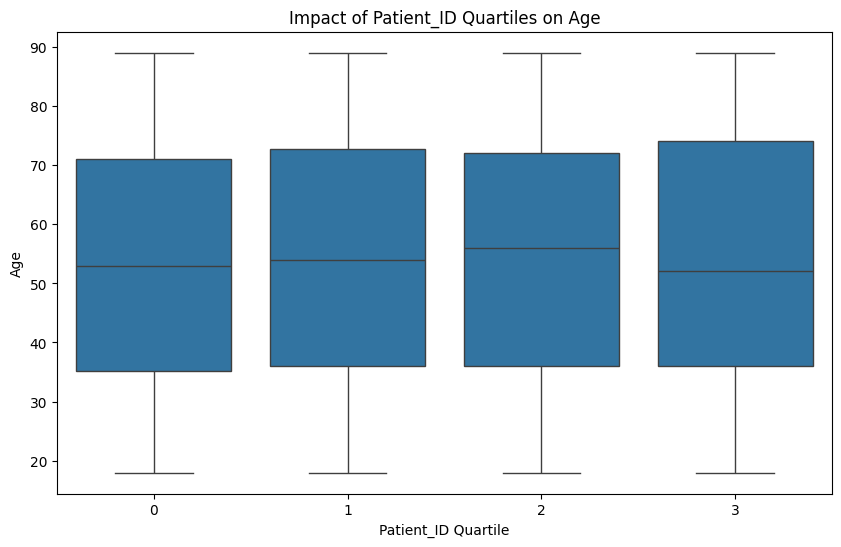

In [122]:
# --- DISCOUNT IMPACT ON RATING (Adaptation for general data) ---
# This requires 'discount' and 'rating' columns. For a general dataset,
# we'll use a numerical feature and a potentially "rating-like" numerical feature.
print("\n--- Impact of a Numerical Feature on Another (General Adaptation for 'Discount Impact on Rating') ---")
if len(numerical_cols) >= 2:
    # Assuming the first numerical column is 'discount-like' and the second is 'rating-like'
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=pd.qcut(df[numerical_cols[0]], q=4, labels=False, duplicates='drop'), y=df[numerical_cols[1]])
    plt.title(f'Impact of {numerical_cols[0]} Quartiles on {numerical_cols[1]}')
    plt.xlabel(f'{numerical_cols[0]} Quartile')
    plt.ylabel(numerical_cols[1])
    plt.show()
else:
    print("Not enough numerical columns to show a 'Discount Impact on Rating' equivalent.")



--- Feature Relationships by Top Categories (General Adaptation for 'by Brands') ---


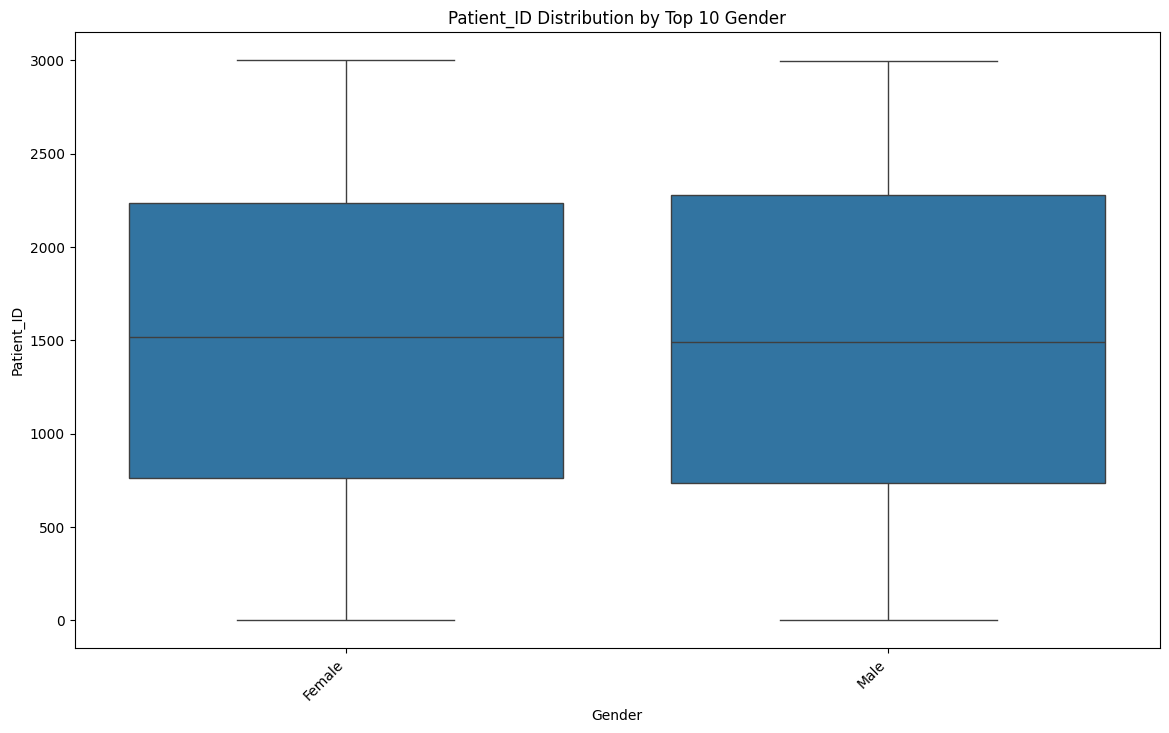

In [124]:
# --- FEATURE RELATIONSHIPS BY BRANDS (Adaptation for general data) ---
# This requires a categorical column (like 'Brand') and other features.
print("\n--- Feature Relationships by Top Categories (General Adaptation for 'by Brands') ---")
if len(numerical_cols) > 0 and len(categorical_cols) > 0:
    # Using the first categorical column as 'category' and first numerical as 'feature'
    plt.figure(figsize=(14, 8))
    sns.boxplot(x=df[categorical_cols[0]], y=df[numerical_cols[0]], order=df[categorical_cols[0]].value_counts().head(10).index)
    plt.title(f'{numerical_cols[0]} Distribution by Top 10 {categorical_cols[0]}')
    plt.xlabel(categorical_cols[0])
    plt.ylabel(numerical_cols[0])
    plt.xticks(rotation=45, ha='right')
    plt.show()
else:
    print("Not enough suitable columns for 'Feature Relationships by Brands' equivalent.")



--- Numerical Feature Distribution Across Top Categories (General Adaptation for 'Price Distribution') ---


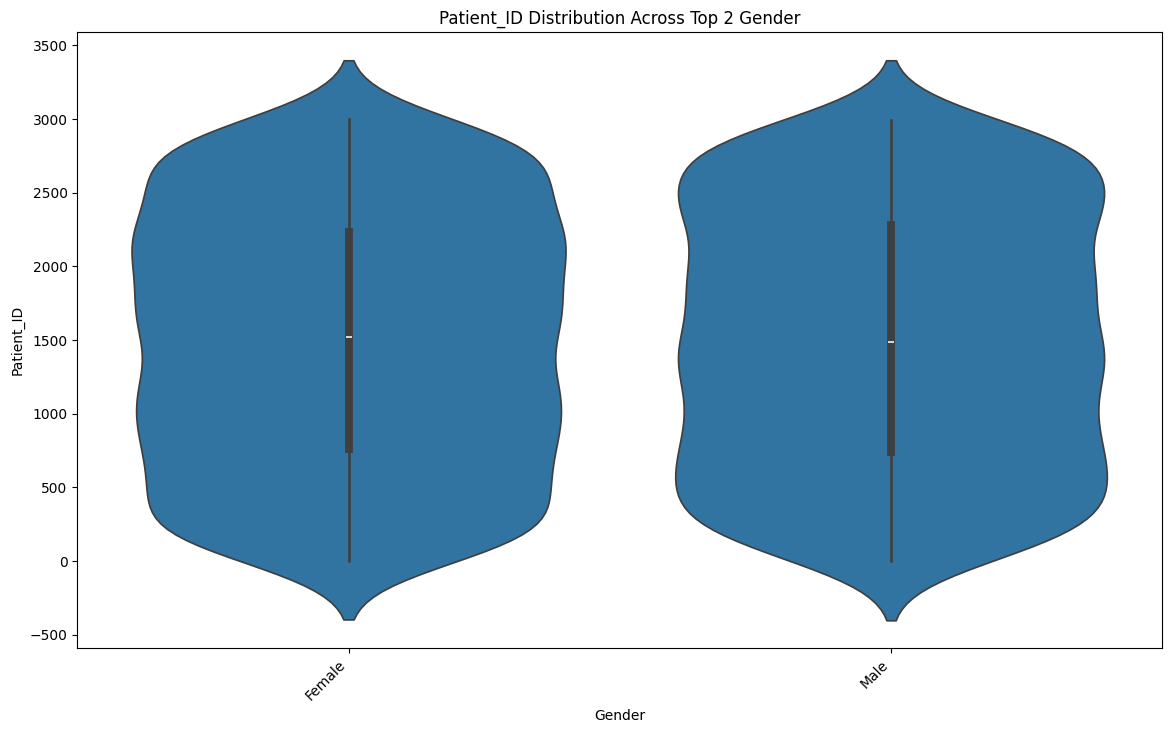

In [126]:
# --- PRICE DISTRIBUTION ACROSS TOP BRANDS (Adaptation for general data) ---
# This requires a 'price' and 'brand' column.
print("\n--- Numerical Feature Distribution Across Top Categories (General Adaptation for 'Price Distribution') ---")
if len(numerical_cols) > 0 and len(categorical_cols) > 0:
    top_categories = df[categorical_cols[0]].value_counts().head(10).index
    df_filtered = df[df[categorical_cols[0]].isin(top_categories)]
    plt.figure(figsize=(14, 8))
    sns.violinplot(x=df_filtered[categorical_cols[0]], y=df_filtered[numerical_cols[0]], order=top_categories)
    plt.title(f'{numerical_cols[0]} Distribution Across Top {len(top_categories)} {categorical_cols[0]}')
    plt.xlabel(categorical_cols[0])
    plt.ylabel(numerical_cols[0])
    plt.xticks(rotation=45, ha='right')
    plt.show()
else:
    print("Not enough suitable columns for 'Price Distribution Across Top Brands' equivalent.")


In [130]:
# --- MACHINE LEARNING PART ---
print("\n--- Machine Learning Part ---")



--- Machine Learning Part ---


In [132]:
 #Preprocessing for ML: Handle categorical features and scale numerical ones
ml_df = df.copy()



In [134]:
# Identify categorical and numerical columns for ML
ml_categorical_cols = ml_df.select_dtypes(include='object').columns
ml_numerical_cols = ml_df.select_dtypes(include=['int64', 'float64']).columns


In [136]:
# Label Encoding for categorical features
for col in ml_categorical_cols:
    le = LabelEncoder()
    ml_df[col] = le.fit_transform(ml_df[col])
    print(f"Label encoded '{col}'")

Label encoded 'Gender'
Label encoded 'Region'
Label encoded 'Preexisting_Condition'
Label encoded 'Date_of_Infection'
Label encoded 'COVID_Strain'
Label encoded 'Symptoms'
Label encoded 'Severity'
Label encoded 'Hospitalized'
Label encoded 'Hospital_Admission_Date'
Label encoded 'Hospital_Discharge_Date'
Label encoded 'ICU_Admission'
Label encoded 'Ventilator_Support'
Label encoded 'Recovered'
Label encoded 'Date_of_Recovery'
Label encoded 'Reinfection'
Label encoded 'Date_of_Reinfection'
Label encoded 'Vaccination_Status'
Label encoded 'Vaccine_Type'
Label encoded 'Date_of_Last_Dose'
Label encoded 'Long_COVID_Symptoms'
Label encoded 'Occupation'
Label encoded 'Smoking_Status'


In [138]:
# Check if there are enough numerical columns for a target for prediction
if len(ml_numerical_cols) >= 1:
    target_prediction_col = ml_numerical_cols[0] # Using the first numerical column as target for prediction
    print(f"\nTarget for Price Prediction (General Adaptation): '{target_prediction_col}'")

    if target_prediction_col in ml_df.columns and len(ml_df.columns) > 1:
        X = ml_df.drop(columns=[target_prediction_col])
        y = ml_df[target_prediction_col]

        # Handle any remaining non-numeric columns in X (e.g., if target was the only numerical)
        X = X.select_dtypes(include=np.number)

        if not X.empty:
            # Scaling numerical features
            scaler = StandardScaler()
            X_scaled = scaler.fit_transform(X)
            X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

            X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
            print(f"Shape of X_train: {X_train.shape}, y_train: {y_train.shape}")
            print(f"Shape of X_test: {X_test.shape}, y_test: {y_test.shape}")

            # --- PREDICTING THE PRICE BASED ON SOME FEATURES (General Regression) ---
            print("\n--- Predicting a Numerical Feature based on other Features (General Regression) ---")
            try:
                lin_reg_model = LinearRegression()
                lin_reg_model.fit(X_train, y_train)
                y_pred_reg = lin_reg_model.predict(X_test)
                rmse = np.sqrt(mean_squared_error(y_test, y_pred_reg))
                print(f"Root Mean Squared Error for Regression Model: {rmse:.2f}")
            except Exception as e:
                print(f"Could not perform Linear Regression: {e}")
        else:
            print("Cannot perform regression: No features left after dropping target or non-numeric columns.")
    else:
        print("Cannot perform regression: Target column not found or not enough features.")
else:
    print("Not enough numerical columns to perform a 'Price Prediction' equivalent.")



Target for Price Prediction (General Adaptation): 'Patient_ID'
Shape of X_train: (2400, 25), y_train: (2400,)
Shape of X_test: (600, 25), y_test: (600,)

--- Predicting a Numerical Feature based on other Features (General Regression) ---
Root Mean Squared Error for Regression Model: 882.65



--- Classifying Data into High-Low Groups (General Classification) ---

Target for Classification (High/Low): 'Patient_ID'
Created 'high_low_group' based on 'Patient_ID' (median=1500.5).
high_low_group
0    1500
1    1500
Name: count, dtype: int64
Shape of X_train_cls: (2400, 25), y_train_cls: (2400,)

Accuracy for Classification Model: 0.49

Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.55      0.52       300
           1       0.49      0.44      0.46       300

    accuracy                           0.49       600
   macro avg       0.49      0.49      0.49       600
weighted avg       0.49      0.49      0.49       600


--- Feature Importance (from Classification Model) ---
Top 10 Feature Importances:
BMI                        0.119564
Date_of_Infection          0.118846
Age                        0.102238
Date_of_Recovery           0.073290
Date_of_Last_Dose          0.067714
Occupation                 0.052035
Pree

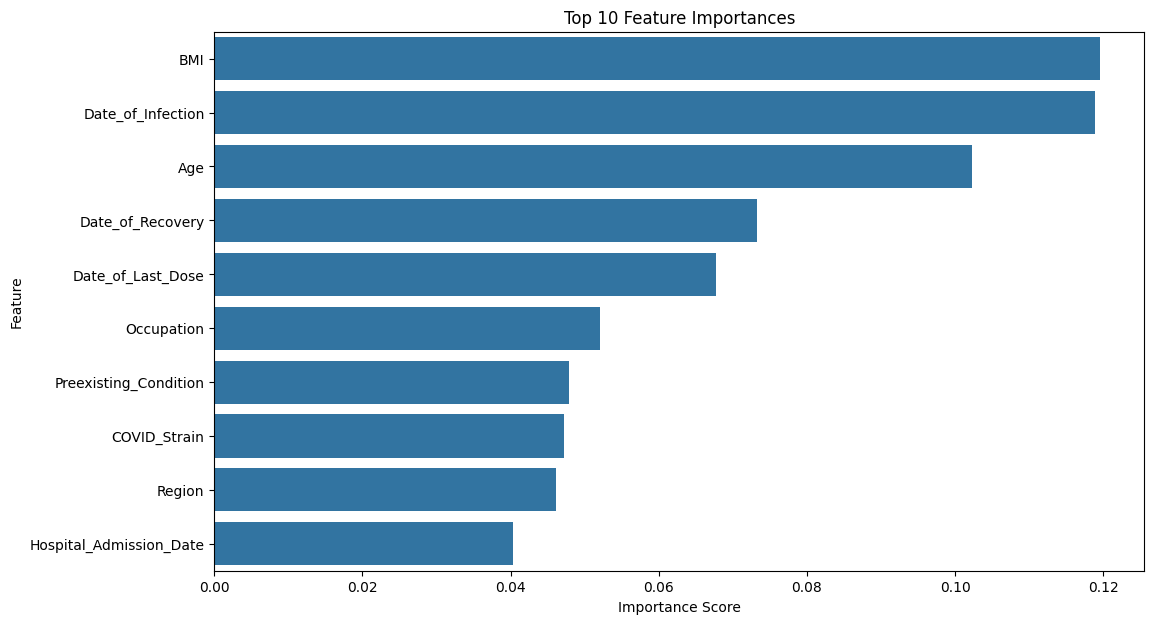


--- Analysis Complete ---


In [140]:
# --- CLASSIFYING THE SMARTPHONES INTO HIGH-LOW RATED GROUPS (General Classification) ---
# This requires a 'rating' column. We'll create a binary classification target
# based on a numerical column (e.g., above/below median).
print("\n--- Classifying Data into High-Low Groups (General Classification) ---")

if len(ml_numerical_cols) >= 1:
    target_classification_col = ml_numerical_cols[0] # Using the first numerical column as target for classification
    print(f"\nTarget for Classification (High/Low): '{target_classification_col}'")

    if target_classification_col in ml_df.columns:
        # Create a binary target: 1 if above median, 0 if below or equal
        median_val = ml_df[target_classification_col].median()
        ml_df['high_low_group'] = (ml_df[target_classification_col] > median_val).astype(int)
        print(f"Created 'high_low_group' based on '{target_classification_col}' (median={median_val}).")
        print(ml_df['high_low_group'].value_counts())

        X_cls = ml_df.drop(columns=[target_classification_col, 'high_low_group'])
        y_cls = ml_df['high_low_group']

        # Handle any remaining non-numeric columns in X_cls
        X_cls = X_cls.select_dtypes(include=np.number)

        if not X_cls.empty:
            scaler_cls = StandardScaler()
            X_cls_scaled = scaler_cls.fit_transform(X_cls)
            X_cls_scaled = pd.DataFrame(X_cls_scaled, columns=X_cls.columns)

            X_train_cls, X_test_cls, y_train_cls, y_test_cls = train_test_split(X_cls_scaled, y_cls, test_size=0.2, random_state=42, stratify=y_cls)
            print(f"Shape of X_train_cls: {X_train_cls.shape}, y_train_cls: {y_train_cls.shape}")

            try:
                rf_classifier = RandomForestClassifier(random_state=42)
                rf_classifier.fit(X_train_cls, y_train_cls)
                y_pred_cls = rf_classifier.predict(X_test_cls)

                accuracy = accuracy_score(y_test_cls, y_pred_cls)
                print(f"\nAccuracy for Classification Model: {accuracy:.2f}")
                print("\nClassification Report:")
                print(classification_report(y_test_cls, y_pred_cls))

                # --- FEATURE IMPORTANCE ---
                print("\n--- Feature Importance (from Classification Model) ---")
                if hasattr(rf_classifier, 'feature_importances_'):
                    feature_importances = pd.Series(rf_classifier.feature_importances_, index=X_cls.columns).sort_values(ascending=False)
                    print("Top 10 Feature Importances:")
                    print(feature_importances.head(10))

                    plt.figure(figsize=(12, 7))
                    sns.barplot(x=feature_importances.head(10).values, y=feature_importances.head(10).index)
                    plt.title('Top 10 Feature Importances')
                    plt.xlabel('Importance Score')
                    plt.ylabel('Feature')
                    plt.show()
                else:
                    print("Feature importances not available for the selected model.")
            except Exception as e:
                print(f"Could not perform Classification: {e}")
        else:
            print("Cannot perform classification: No features left after dropping target or non-numeric columns.")
    else:
        print("Cannot perform classification: Target column not found.")
else:
    print("Not enough numerical columns to perform a 'High-Low Rated Groups' equivalent.")

print("\n--- Analysis Complete ---")